In [82]:
API_KEY = '6669d7a6eb70f4.27564131'
tickers = ['NESN.SW', 'MDLZ.US', 'HSY.US', 'GIS.US', 'KHC.US']  # EODHD requires US suffix for US markets

# Constants for the number of days before earnings and after dividend
DAYS_AFTER_DIVIDEND = 0  # Number of days after the dividend to buy
DAYS_BEFORE_EARNINGS = 0  # Number of days before earnings to sell

# Define the period of analysis
start_date = '2014-01-01'
end_date = '2025-01-01'

# Initial nominal investment in each stock
initial_investment = 1000

In [83]:
# Block 2: Data Retrieval

import requests
import io
import pandas as pd

pd.set_option('display.max_rows', 20)  # Show all rows

# Helper function to download price data from the API
def fetch_price_data(ticker):
    prices_url = f"https://eodhd.com/api/eod/{ticker}?from={start_date}&to={end_date}&api_token={API_KEY}&fmt=json"
    response = requests.get(prices_url)
    print(response, " ", prices_url)
    
    if response.status_code == 200:
        prices = pd.read_json(io.StringIO(response.text))
        prices['date'] = pd.to_datetime(prices['date'])
        prices.set_index('date', inplace=True)
        # Print diagnostics for earnings dates
        print(prices)
        return prices[['adjusted_close']]  # Only return the 'adjusted_close' price column
    else:
        print(f"Error fetching prices for {ticker}: {response.status_code}")
        return pd.DataFrame()

# Helper function to download earnings data from the API
def fetch_earnings_data(ticker):
    earnings_url = f"https://eodhd.com/api/calendar/earnings?api_token={API_KEY}&from={start_date}&to={end_date}&symbols={ticker}"
    response = requests.get(earnings_url)
    print(response, " ", earnings_url)
    
    if response.status_code == 200 and response.text.strip() != "":
        try:
            earnings = pd.read_csv(io.StringIO(response.text))
            earnings_dates = earnings['Report_Date'].dropna().unique()
            # Print diagnostics for earnings dates
            earnings_dates_str = ', '.join(earnings_dates)
            print(f"Earnings Dates for {ticker}: {earnings_dates_str}")
            return earnings_dates
        except Exception as e:
            print(f"Error processing earnings data for {ticker}: {e}")
            return []
    else:
        print(f"Error fetching earnings for {ticker}: {response.status_code}")
        return []

# Helper function to download dividend data from the API
def fetch_dividend_data(ticker):
    dividends_url = f"https://eodhd.com/api/div/{ticker}?from={start_date}&to={end_date}&api_token={API_KEY}&fmt=json"
    response = requests.get(dividends_url)
    print(response, " ", dividends_url)

    if response.status_code == 200 and response.text.strip() != "":
        try:
            dividends = response.json()
            dividend_dates = [pd.to_datetime(item['date']) for item in dividends if 'date' in item]
            # Print diagnostics for dividend dates
            dividend_dates_str = ', '.join([date.strftime('%Y-%m-%d') for date in dividend_dates])
            print(f"Dividend Dates for {ticker}: {dividend_dates_str}")
            return dividend_dates
        except Exception as e:
            print(f"Error processing dividend data for {ticker}: {e}")
            return []
    else:
        print(f"Error fetching dividends for {ticker}: {response.status_code}")
        return []

# Placeholder for downloaded data
downloaded_data = {}

# Open a file to log CSV data
    
# Fetch prices, earnings, and dividends for each stock
for ticker in tickers:
    print(f"\nFetching data for {ticker}...")

    # Fetch the prices, earnings, and dividends
    prices_df = fetch_price_data(ticker)
    earnings_dates = fetch_earnings_data(ticker)
    dividend_dates = fetch_dividend_data(ticker)
    
    # Convert dates to strings for CSV logging
    earnings_dates_str = ', '.join([str(date) for date in earnings_dates])
    dividend_dates_str = ', '.join([date.strftime('%Y-%m-%d') for date in dividend_dates])

    # Store the fetched data for later use
    downloaded_data[ticker] = {
        'prices': prices_df,
        'earnings_dates': earnings_dates,
        'dividends': dividend_dates
    }

print("\nData retrieval completed!")



Fetching data for NESN.SW...
<Response [200]>   https://eodhd.com/api/eod/NESN.SW?from=2014-01-01&to=2025-01-01&api_token=6669d7a6eb70f4.27564131&fmt=json
             open   high    low  close  adjusted_close   volume
date                                                           
2014-01-03  65.00  66.20  64.95  66.15         48.3955  5841795
2014-01-06  65.90  66.05  65.60  66.00         48.2858  5687495
2014-01-07  66.15  67.00  66.10  66.45         48.6150  6253074
2014-01-08  66.45  66.50  65.80  66.45         48.6150  6999434
2014-01-09  66.45  66.45  65.45  65.60         47.9932  5019013
...           ...    ...    ...    ...             ...      ...
2024-09-02  91.04  91.10  90.24  90.64         90.6400  2984709
2024-09-03  91.00  91.72  90.72  91.48         91.4800  4414223
2024-09-04  91.64  91.66  89.46  89.64         89.6400  3714087
2024-09-05  89.30  89.48  88.48  88.48         88.4800  5182973
2024-09-06  88.36  88.94  87.54  87.54         87.5400  5420943

[2686 rows 

In [84]:
# Helper function to find the nearest valid date for price lookup
def get_nearest_date(df, target_date):
    if target_date in df.index:
        return target_date
    nearest_idx = df.index.get_indexer([target_date], method='nearest')
    nearest_date = df.index[nearest_idx[0]]
    return nearest_date

# Placeholder for cumulative returns data and nominal investment values
investment_data = {}
diagnostic_data = []

# Loop over each stock and simulate the strategy
for ticker, data in downloaded_data.items():
    print(f"\nProcessing {ticker} for strategy...")  # Diagnostic output
    
    # Extract the relevant data
    prices = data['prices']
    dividends = data['dividends']
    earnings_dates = data['earnings_dates']
    
    # Ensure that we have earnings dates and dividends data to process
    if len(earnings_dates) == 0:  # Check if earnings_dates is empty
        print(f"No earnings dates available for {ticker}. Skipping...")
        continue

    if len(dividends) == 0:  # Check if dividends is empty
        print(f"No dividend data available for {ticker}. Skipping...")
        continue

    # Now, simulate the buy-sell strategy
    cumulative_investment = initial_investment  # Start with $1,000 initial investment
    cumulative_values = []  # Track cumulative value after each trade
    trade_dates = []  # Track the trade dates
    
    for ex_dividend_date in dividends:
        try:
            # Ensure ex_dividend_date is timezone-naive (just in case)
            ex_dividend_date = pd.Timestamp(ex_dividend_date).tz_localize(None)
            
            # Find the nearest valid date to buy a certain number of days after the ex-dividend date
            buy_date = get_nearest_date(prices, ex_dividend_date + pd.DateOffset(days=DAYS_AFTER_DIVIDEND))
            buy_price = prices.loc[buy_date]['adjusted_close']
            
            # Get the next earnings date and sell a certain number of days before it
            next_earnings_dates = [pd.Timestamp(date) for date in earnings_dates if pd.Timestamp(date) > buy_date]
            if not next_earnings_dates:
                print(f"No future earnings date available for {ticker} after {buy_date}")
                continue
            
            next_earnings_date = min(next_earnings_dates)
            sell_date = get_nearest_date(prices, next_earnings_date - pd.DateOffset(days=DAYS_BEFORE_EARNINGS))
            sell_price = prices.loc[sell_date]['adjusted_close']
            
            # Calculate percentage return for this trade
            trade_return = (sell_price - buy_price) / buy_price * 100
            cumulative_value = cumulative_investment * (1 + (trade_return / 100))
            
            # Diagnostic: Print buy/sell details, % gain, and cumulative funds
            print(f"Trade on {ticker}: Buy on {buy_date} at {buy_price:.2f}, Sell on {sell_date} at {sell_price:.2f}, "
                  f"Return: {trade_return:.2f}%, Cumulative Value: {cumulative_value:.2f} $")
            
            # Store the result for cumulative investment
            cumulative_values.append(cumulative_value)
            trade_dates.append(sell_date)
            
            # Update cumulative investment for the next trade
            cumulative_investment = cumulative_value
        
        except KeyError as e:
            print(f"KeyError for {ticker}: {e}")
            continue

    # Store cumulative values for the stock over time
    if len(cumulative_values) > 0:
        investment_data[ticker] = pd.Series(cumulative_values, index=trade_dates).groupby(level=0).sum()

print("\nProcessing completed!")



Processing NESN.SW for strategy...
Trade on NESN.SW: Buy on 2014-04-14 00:00:00 at 50.59, Sell on 2014-08-08 00:00:00 at 52.02, Return: 2.84%, Cumulative Value: 1028.38 $
Trade on NESN.SW: Buy on 2015-04-20 00:00:00 at 57.58, Sell on 2015-08-14 00:00:00 at 58.32, Return: 1.28%, Cumulative Value: 1041.58 $
Trade on NESN.SW: Buy on 2016-04-11 00:00:00 at 56.25, Sell on 2016-08-19 00:00:00 at 63.36, Return: 12.63%, Cumulative Value: 1173.17 $
Trade on NESN.SW: Buy on 2017-04-10 00:00:00 at 62.59, Sell on 2017-07-28 00:00:00 at 67.64, Return: 8.07%, Cumulative Value: 1267.83 $
Trade on NESN.SW: Buy on 2018-04-16 00:00:00 at 63.77, Sell on 2018-07-27 00:00:00 at 69.49, Return: 8.97%, Cumulative Value: 1381.61 $
Trade on NESN.SW: Buy on 2019-04-15 00:00:00 at 82.71, Sell on 2019-07-29 00:00:00 at 92.23, Return: 11.51%, Cumulative Value: 1540.62 $
Trade on NESN.SW: Buy on 2020-04-27 00:00:00 at 93.71, Sell on 2020-07-31 00:00:00 at 97.22, Return: 3.74%, Cumulative Value: 1598.28 $
Trade on N

Investment Data to be plotted:
                NESN.SW      MDLZ.US       HSY.US       GIS.US       KHC.US
2013-12-31  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000
2014-03-21          NaN          NaN          NaN  1031.534034          NaN
2014-04-25          NaN          NaN   898.670853          NaN          NaN
2014-05-02          NaN          NaN          NaN          NaN   987.436794
2014-05-09          NaN  1115.487735          NaN          NaN          NaN
...                 ...          ...          ...          ...          ...
2024-05-06          NaN          NaN  1644.034179          NaN          NaN
2024-06-28          NaN          NaN          NaN  1239.940767          NaN
2024-08-01          NaN  3282.369684          NaN          NaN          NaN
2024-08-02          NaN          NaN  1604.068991          NaN   871.746504
2024-09-06  1412.461408  3282.369684  1641.113137  1498.952391   896.253434

[154 rows x 5 columns]


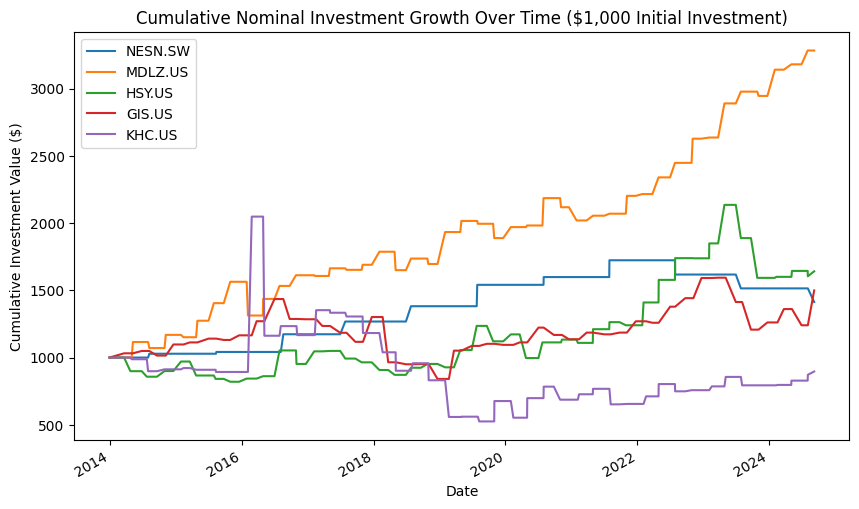

In [85]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt

# Create DataFrame for nominal dollar values
investment_df = pd.DataFrame(investment_data)

# Calculate the day before the start date dynamically
initial_investment_date = pd.to_datetime(start_date) - pd.Timedelta(days=1)  # Subtract one day

# Add a row for the day before the start of the simulation
initial_investment_row = pd.Series({ticker: 1000 for ticker in investment_df.columns}, name=initial_investment_date)

# Insert the row into the DataFrame
investment_df = pd.concat([pd.DataFrame([initial_investment_row]), investment_df])

print("Investment Data to be plotted:")
print(investment_df)

# Forward fill to handle NaN values
investment_df.ffill(inplace=True)

# Plot the cumulative nominal investment values over time
fig, ax = plt.subplots(figsize=(10, 6))
investment_df.plot(kind='line', ax=ax, title='Cumulative Nominal Investment Growth Over Time ($1,000 Initial Investment)')
plt.ylabel('Cumulative Investment Value ($)')
plt.xlabel('Date')
plt.show()


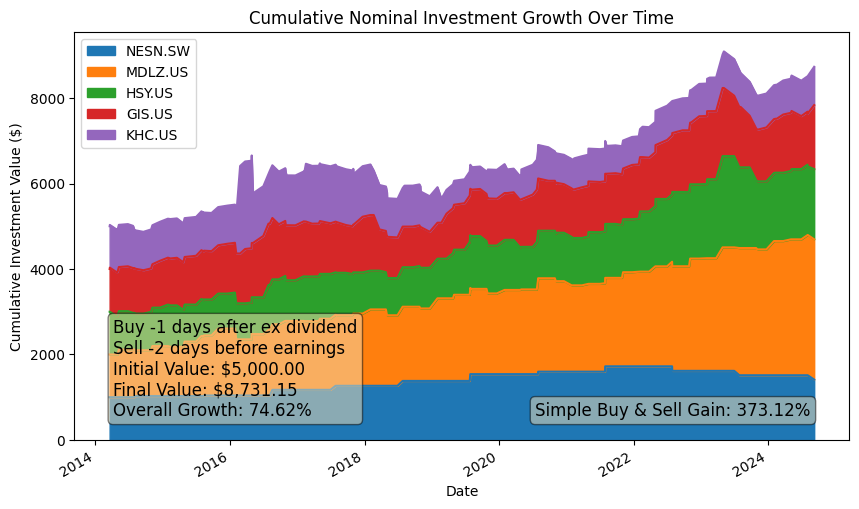

Investment Data after Forward Fill:
                NESN.SW      MDLZ.US       HSY.US       GIS.US       KHC.US
2014-03-20  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000
2014-03-21  1000.000000  1000.000000  1000.000000  1031.534034  1000.000000
2014-04-25  1000.000000  1000.000000   898.670853  1031.534034  1000.000000
2014-05-02  1000.000000  1000.000000   898.670853  1031.534034   987.436794
2014-05-09  1000.000000  1115.487735   898.670853  1031.534034   987.436794
...                 ...          ...          ...          ...          ...
2024-05-06  1514.112161  3179.780615  1644.034179  1360.486413   828.473269
2024-06-28  1514.112161  3179.780615  1644.034179  1239.940767   828.473269
2024-08-01  1514.112161  3282.369684  1644.034179  1239.940767   828.473269
2024-08-02  1514.112161  3282.369684  1604.068991  1239.940767   871.746504
2024-09-06  1412.461408  3282.369684  1641.113137  1498.952391   896.253434

[154 rows x 5 columns]


In [86]:
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame for nominal dollar values
investment_df = pd.DataFrame(investment_data)

# Calculate the day before the start date dynamically
start_date = investment_df.index.min()  # Get the earliest date in the DataFrame
initial_investment_date = start_date - pd.Timedelta(days=1)  # Subtract one day

# Add a row for the day before the start of the simulation
initial_investment_row = pd.Series({ticker: 1000 for ticker in investment_df.columns}, name=initial_investment_date)

# Insert the row into the DataFrame
investment_df = pd.concat([pd.DataFrame([initial_investment_row]), investment_df])

# Forward fill to handle NaN values
investment_df.ffill(inplace=True)

# Calculate the total initial investment and final investment value
initial_value = investment_df.iloc[0].sum()  # Sum of investments at the start
final_value = investment_df.iloc[-1].sum()  # Sum of investments at the end

# Calculate overall growth percentage
growth_percentage = ((final_value - initial_value) / initial_value) * 100

# Calculate the gain with no other buy/sell operations
simple_buy_sell_gain = (investment_df.iloc[-1] - investment_df.iloc[0]) / investment_df.iloc[0] * 100
simple_total_gain = simple_buy_sell_gain.sum()  # Sum the gains for a total overview

# Plot the stacked area chart with forward-filled data
fig, ax = plt.subplots(figsize=(10, 6))
investment_df.plot(kind='area', stacked=True, ax=ax, title='Cumulative Nominal Investment Growth Over Time')
plt.ylabel('Cumulative Investment Value ($)')
plt.xlabel('Date')

# Add a text box with the final value and growth percentage in the bottom-left corner
textstr = f'Buy {DAYS_AFTER_DIVIDEND} days after ex dividend\nSell {DAYS_BEFORE_EARNINGS} days before earnings\nInitial Value: ${initial_value:,.2f}\nFinal Value: ${final_value:,.2f}\nOverall Growth: {growth_percentage:.2f}%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.05, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='bottom', bbox=props)

# Add a second text box with the gain from simple buy and sell operation
textstr2 = f'Simple Buy & Sell Gain: {simple_total_gain:.2f}%'
ax.text(0.95, 0.05, textstr2, transform=ax.transAxes, fontsize=12,
        verticalalignment='bottom', horizontalalignment='right', bbox=props)

# Show the plot
plt.show()

# Diagnostic to check the forward-filled data
print("Investment Data after Forward Fill:")
print(investment_df)
